In [1]:
from Tools.utils import *

In [9]:
### load shapes

# choose the shapes (among [0,49])
i1 = 4; i2 = 0;

### PATHS
datafolder = 'data/SMAL_r/'
arr_files = np.loadtxt(join(datafolder,'mesh_names.txt'), dtype=np.str)

filename1 = join(datafolder,arr_files[i1]+'.obj') #join(datafolder, filename.format(i1))
filename2 = join(datafolder,arr_files[i2]+'.obj') #join(datafolder, filename.format(i2))
###

## load (or compute and save) spectral data
k = 100

# real eigenvectors
X = mesh(filename1, spectral=k)
Y = mesh(filename2, spectral=k)

X.center_and_scale(scale=True)
Y.center_and_scale(scale=True)
X.v *= [1,-1,-1]  # for visualization
Y.v *= [1,-1,-1]

# ground-truth correspondence
vts_folder = 'cor'
X.get_vts(cor_folder=vts_folder); Y.get_vts(cor_folder=vts_folder)

# complex eigenvectors
X.complex_spectral(k=k)
Y.complex_spectral(k=k)

# for Q->p2p to get unoriented diracs
# X.gpdir stores the unoriented Diracs one can choose to put oriented Diracs as it
# sometimes yields better results
X.gradv = X.grad_vert_op(); Y.gradv = Y.grad_vert_op();
X.gpdir = X.div_c_vert_op()@X.ceig; Y.gpdir = Y.div_c_vert_op()@Y.ceig
#X.gpdir = X.ceig; Y.gpdir = Y.ceig

area was 2.6556472092097283
area was 3.6356965316800607


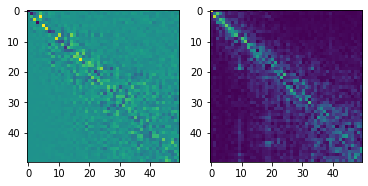

In [10]:
# compute ground-truth fmap and get complex fmap

kgt = 50
kgtQ = 50
C12_gt = np.linalg.pinv(Y.eig[Y.vts,:kgt]) @ X.eig[X.vts, :kgt]
Q12_gt = CMap2QMap_procrustes(X,Y,C12_gt,kgtQ)
T12_gt = fMap2pMap(Y.eig, X.eig, C12_gt.T)

plt.subplot(121)
plt.imshow(C12_gt)
plt.subplot(122)
plt.imshow(np.abs(Q12_gt))

In [22]:
k_init = 3  #3
k_step = 2
k_final = 20
N_inter = 10

# random initialization as in Discrete Optimisation (Ren et al., SGP 2021)
# different runs for this cell will end up with different results
T12_ini = initialize_pMap(X.v.shape[0], Y.v.shape[0])
T21_ini = initialize_pMap(Y.v.shape[0], X.v.shape[0])
#
C21_ini = pMap2fMap(X.eig[:,:k_init], Y.eig[:,:k_init], T12_ini)
C12_ini = pMap2fMap(Y.eig[:,:k_init], X.eig[:,:k_init], T21_ini)

# one can choose to start with deterministic init, for instance reduced gt
#C12_ini = C12_gt[:k_init,:k_init]
#C21_ini = C12_ini.T
#T12_ini = fMap2pMap(Y.eig, X.eig, C21_ini)

# ************************ bijective zoomout **************************
# (w1 and w2 for X->Y and Y->X energies)
# (+ isometric discrete optimisation if w3>0)
# (+ wQ=1/0 to use/not use our method)

C12, C21 = func_bijective_zm_fmap(X, Y, C12_ini, C21_ini, k_init=k_init,
                                  k_step=k_step, k_final=k_final, N_inter=N_inter,
                                  wQ=1,
                                  w1=1, w2=1, w3=1, verbose=0)

# ************************ classic zoomout **************************
# (+ wQ=1/0 to use/not use our method)
# notice that standard zoomout produces worse maps in general

# C21 = func_zm_fmap(X,Y,C21_ini,k_init=k_init, 
#                      k_step=k_step, k_final=k_final, N_inter=N_inter,
#                      wQ=1)

# convert to pmap
T12 = fMap2pMap(Y.eig, X.eig, C21)

# plot using meshplot
show_p2p(X,Y,T12, withuv=0, T12_gt=T12_gt, axis_col=0)

step: 3
step: 5
step: 7
step: 9
step: 11
step: 13
step: 15
step: 17
step: 19
euc err: 0.045943550798759905


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.011306…